# Feature Selection

There are 156 features in the dataset that could be used to predict the target variable-metastatic_diagnosis_period. It is possible that collinearity and multicollinearity exist among features which may cause a drop in model performance. There is also a possibility that some features in the dataset might not contribute to predicting the target.

To identify the top features for initial analysis and aid any future null handling and feature engineering, the following methods were used.
- Distance Correlation
- Feature Importance Score - after fitting 4 tree-based models on the dataset
- Recursive Feature Elimination (RFE)

All features that did not have >90% of their data missing ("metastatic_first_novel_treatment_type", "metastatic_first_novel_treatment") or only one type of data entry ("patient_gender"), were used for the analysis. Additionally, no feature engineering was performed.

For null handling:
- Dropping rows with NaN values: Here, distance correlation gave the best results.
- Using median value to fill NaN: Feature Importance Score provided by CatBoost peformed the best.
- Using mean value to fill NaN: Feature Importance Score provided by CatBoost peformed the best.

The top 15 features identified in order of importance: 'patient_age', 'breast_cancer_diagnosis_desc', 'breast_cancer_diagnosis_code', 'Average of Mar-13', 'patient_zip3', 'bmi', 'commute_time' 'race_native', 'rent_burden', 'income_household_25_to_35', 'age_10_to_19', 'race_white', 'Average of Jul-15', 'population', 'age_20s'

Further work is required to determine if results change when improved null handling strategies are used. Additionally, an analysis of the top 15 features listed above will need to be conducted to determine how they contribute to predicting the metastatic_diagnosis_period.

In [1]:
import pandas as pd
import dcor
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

import warnings

warnings.filterwarnings("ignore")

## Feature Selection Using a Statistical Measure (Distance Correlation)

In [2]:
df = pd.read_csv("train.csv")

#Drop columns with several missing values/only 1 data entry for all columns + patient_id
drop_cols = ["metastatic_first_novel_treatment_type", "metastatic_first_novel_treatment", "patient_gender", "patient_id"]

df = df.drop(columns=drop_cols, axis=1)

In [3]:
categorical_column_names = df.select_dtypes(include=['object']).columns.tolist()
numeric_column_names = df.select_dtypes(include=['number']).columns.tolist()

target_column_name = numeric_column_names.pop(-1)

In [4]:
#Convert categorical columns to dummy variables

modified_df = pd.get_dummies(df, columns=categorical_column_names)
modified_df = modified_df.astype(float)

numerical_cols = modified_df.select_dtypes(include='number').columns
modified_df[numerical_cols] = modified_df[numerical_cols].fillna(modified_df[numerical_cols].median())

In [5]:
def distanceCorrelation(df, target_column, categorical_columns, threshold1=0.4, threshold2=0.05):

    """
    Calculates distance correlation for every feature against the target variable.
    Also displays 2 plots showcasing the top features based on a threshold.
    Input: dataframe, name of the target_column, list of categorical columns, threshold1 and 2 to display the top features
    Output: returns a correlation dataframe containing the feature name and it's correlation value
    """
    
    cols = [col for col in df.columns if col != target_column]
    
    corr_values = []
    
    for col in cols:
        x = df[target_column]
        y = df[col]
        
        corr = dcor.distance_correlation(x, y)
        
        corr_values.append((col, corr))
    
    corr_df = pd.DataFrame(corr_values, columns=["Feature", "Correlation"])
    
    filtered_corr_df = corr_df[corr_df["Correlation"] > threshold1]
    
    if filtered_corr_df.empty:
        print(f"No columns have a distance correlation value above {threshold1} with {target_column}.")
        return
    
    filtered_corr_df = filtered_corr_df.sort_values(by="Correlation", ascending=False)
    
    plt.figure(figsize=(5,3))
    sns.barplot(x="Correlation", y="Feature", data=filtered_corr_df, palette="coolwarm")
    plt.title(f'Columns with Distance Correlation Above {threshold1} with {target_column}')
    plt.show()

    dummy_prefixes = categorical_columns
    averaged_corr_values = {}

    og_corr_df = corr_df.copy()

    for prefix in dummy_prefixes:
        dummy_cols = corr_df[corr_df["Feature"].str.startswith(prefix)]
        if not dummy_cols.empty:
            avg_corr = dummy_cols["Correlation"].mean()
            averaged_corr_values[prefix] = avg_corr
            corr_df = corr_df[~corr_df["Feature"].str.startswith(prefix)]

    avg_corr_df = pd.DataFrame(averaged_corr_values.items(), columns=["Feature", "Correlation"])

    corr_df = pd.concat([corr_df, avg_corr_df], ignore_index=True)

    filtered_corr_df = corr_df[corr_df["Correlation"] > threshold2]
    
    filtered_corr_df = filtered_corr_df.sort_values(by="Correlation", ascending=False)
    
    plt.figure(figsize=(5,3))
    sns.barplot(x="Correlation", y="Feature", data=filtered_corr_df, palette="coolwarm")
    plt.title(f'Columns with Distance Correlation Above {threshold2} with {target_column} after grouping')
    plt.show()
    return og_corr_df

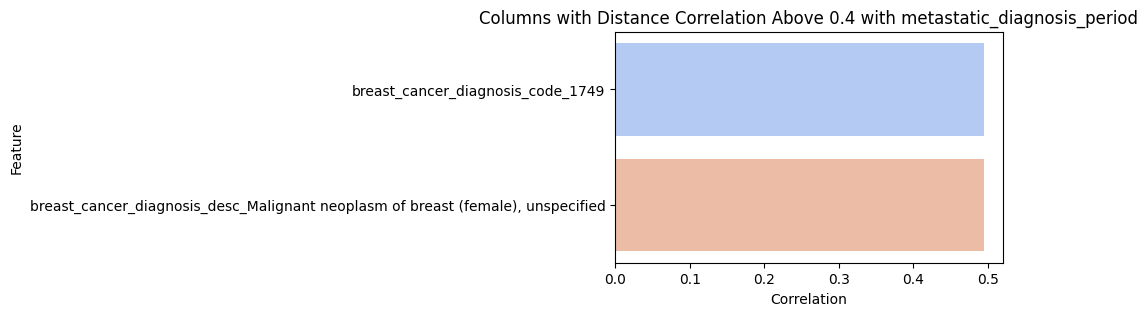

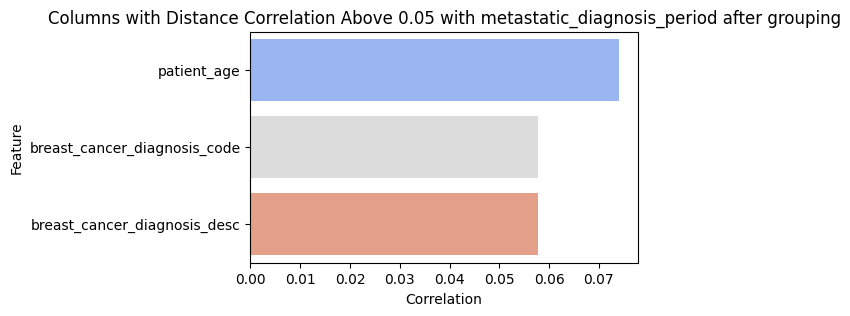

In [6]:
og_corr_df = distanceCorrelation(modified_df, target_column_name, categorical_column_names)

Based on the above, it can be seen that the correlation with metastatic_diagnosis_period is very low. To better understand features that could be used for prediction, feature selection using tree based models will be conducted below.

## Feature Selection Using Tree Based Models (CatBoost, XGBoost, AdaBoost)

In [7]:
X = modified_df.drop(columns=[target_column_name])
y = modified_df[target_column_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def train_model_and_select_features(model, X_train, X_test, y_train, categorical_columns, top_n_features=15):
    """
    Performs model training and creates a feature importance dataframe.
    Input: model, data, name of categorical columns
    Output: list of top features, dataframe of features with their importance score
    """
    
    model.fit(X_train, y_train)

    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    else:
        feature_importances = None

    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = None

    if feature_importances is not None:
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        })
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
        top_features = feature_importance_df['Feature'].iloc[:top_n_features]
    else:
        top_features = None
    
    averaged_importance_values = {}

    #This groups back catgeorical columns that were split when pd.get_dummies() was used
    #The mean importance score is assigned to each categorical column
    for prefix in categorical_columns:
        dummy_cols = feature_importance_df[feature_importance_df["Feature"].str.startswith(prefix)]
        if not dummy_cols.empty:
            avg_importance = dummy_cols["Importance"].mean()
            averaged_importance_values[prefix] = avg_importance
            feature_importance_df = feature_importance_df[~feature_importance_df["Feature"].str.startswith(prefix)]

    avg_importance_df = pd.DataFrame(averaged_importance_values.items(), columns=["Feature", "Importance"])

    feature_importance_df = pd.concat([feature_importance_df, avg_importance_df], ignore_index=True)

    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    return top_features, feature_importance_df


def evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test):

    """
    Displays the mean error score for each model.
    Input: model, data
    """
    
    model.fit(X_train_selected, y_train)

    predictions = model.predict(X_test_selected)
    
    if isinstance(model, (LogisticRegression, RandomForestRegressor, AdaBoostRegressor, XGBRegressor, CatBoostRegressor)):
        score = mean_squared_error(y_test, predictions, squared=False)
        print(f'RMSE with selected features: {score}')
    else:
        print('Model type not recognized for evaluation.')

def plot_top_features(feature_importance_df, model_name, top_n=15):

    """
    Plots the top_n features for each model.
    Input: dataframe containing feature importance scores, model name
    """
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="coolwarm")
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.title(f'Top {top_n} Features for {model_name}')
    plt.show()

RandomForestRegressor


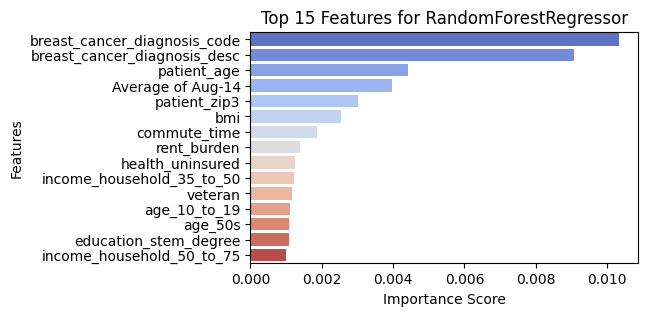

RMSE with selected features: 83.70116232419386

AdaBoostRegressor


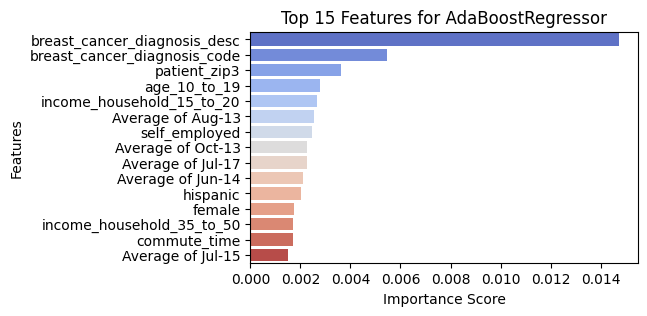

RMSE with selected features: 93.40476080530927

XGBRegressor


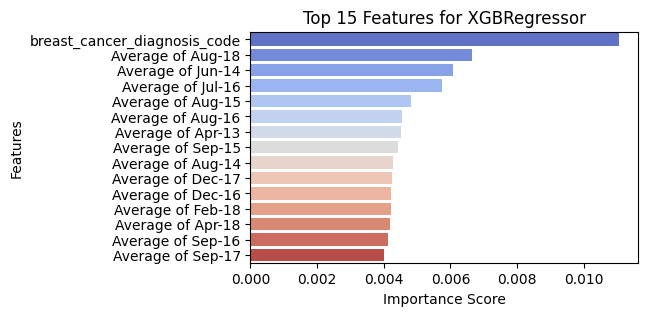

RMSE with selected features: 84.70587872445972

CatBoostRegressor


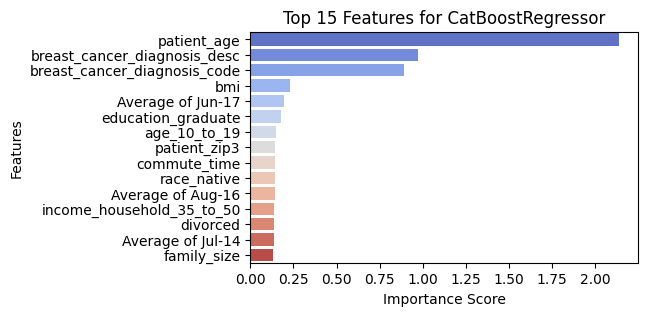

RMSE with selected features: 81.79531685487869



In [9]:
models = [
    RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42),
    AdaBoostRegressor(n_estimators=100, random_state=42),
    XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42),
    CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0, random_state=42)
]

model_feature_importances = {}

for model in models:
    print(f"{type(model).__name__}")
    
    top_features, feature_importance_df = train_model_and_select_features(model, X_train, X_test, y_train, categorical_column_names)
    
    model_name = type(model).__name__
    model_feature_importances[model_name] = feature_importance_df
    
    plot_top_features(feature_importance_df.head(15), type(model).__name__)
    
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    
    evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)
    print()

The best performing model here is CatBoost and the most important features identified by the model are displayed above.

## Applying Recursive Feature Elimination (RFE) to CatBoost

In [10]:
catboost_model = CatBoostRegressor(iterations=100, depth=3, learning_rate=0.1, verbose=0)

rfe = RFE(estimator=catboost_model)

rfe.fit(X_train, y_train)

RFE(estimator=<catboost.core.CatBoostRegressor object at 0x000001EA54428750>)

In [11]:
feature_names = X_train.columns
feature_ranking = rfe.ranking_

ranking_df = pd.DataFrame({'Feature': feature_names, 'Ranking': feature_ranking})

selected_features_sorted = ranking_df[ranking_df["Ranking"]==1].sort_values(by='Ranking')

print(f"The top features are: {list(selected_features_sorted['Feature'])}")

The top features are: ['patient_age', 'breast_cancer_diagnosis_code_C50311', 'breast_cancer_diagnosis_code_C50312', 'breast_cancer_diagnosis_code_C50319', 'breast_cancer_diagnosis_code_C5041', 'breast_cancer_diagnosis_code_C50411', 'breast_cancer_diagnosis_code_C50412', 'breast_cancer_diagnosis_code_C50419', 'breast_cancer_diagnosis_code_C50421', 'breast_cancer_diagnosis_code_C50511', 'breast_cancer_diagnosis_code_C50512', 'breast_cancer_diagnosis_code_C50519', 'breast_cancer_diagnosis_code_C50611', 'breast_cancer_diagnosis_code_C50612', 'breast_cancer_diagnosis_code_C50619', 'breast_cancer_diagnosis_code_C5081', 'breast_cancer_diagnosis_code_C50811', 'breast_cancer_diagnosis_code_C50812', 'breast_cancer_diagnosis_code_C5031', 'breast_cancer_diagnosis_code_C50819', 'breast_cancer_diagnosis_code_C50221', 'breast_cancer_diagnosis_code_C50212', 'breast_cancer_diagnosis_code_1743', 'breast_cancer_diagnosis_code_1744', 'breast_cancer_diagnosis_code_1745', 'breast_cancer_diagnosis_code_1746'

In [12]:
X_train_selected = X_train[selected_features_sorted["Feature"]]
X_test_selected = X_test[selected_features_sorted["Feature"]]


rfe.fit(X_train_selected, y_train)

predictions = rfe.predict(X_test_selected)
    
score = mean_squared_error(y_test, predictions, squared=False)
print(f'RMSE with selected features: {score}')

RMSE with selected features: 82.45184014793094


## Using Features Obtained from Distance Correlation on CatBoost

In [13]:
corr = og_corr_df.sort_values(by="Correlation", ascending=False)
corr = corr[corr["Correlation"]>0.05]

In [14]:
X_train_selected = X_train[corr["Feature"]]
X_test_selected = X_test[corr["Feature"]]

catboost_model.fit(X_train_selected, y_train)

predictions = catboost_model.predict(X_test_selected)
    
score = mean_squared_error(y_test, predictions, squared=False)
print(f'RMSE with selected features: {score}')

RMSE with selected features: 82.01267748169539


## Top Features

In [15]:
print("Top features for CatBoost based on it's feature importance scoring")
model_feature_importances["CatBoostRegressor"][:15]

Top features for CatBoost based on it's feature importance scoring


,Feature,Importance
0,patient_age,2.142170
145,breast_cancer_diagnosis_desc,0.973148
144,breast_cancer_diagnosis_code,0.888913
1,bmi,0.227890
2,Average of Jun-17,0.195234
3,education_graduate,0.177751
4,age_10_to_19,0.147192
5,patient_zip3,0.144368
6,commute_time,0.143725
7,race_native,0.142480


## Resources

- [Multicollinearity - detection and remedies](https://www.kaggle.com/code/marcinrutecki/multicollinearity-detection-and-remedies/notebook#11.-Recursive-Feature-Elimination-(RFE))
- [How to Choose a Feature Selection Method For Machine Learning](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)
- [A Comparison of Correlation Measures](https://m-clark.github.io/docs/CorrelationComparison.pdf)
- [Finding Correlations in Non-Linear Data](https://www.freecodecamp.org/news/how-machines-make-predictions-finding-correlations-in-complex-data-dfd9f0d87889/)